In [1]:
# If you haven't yet installed wot, uncomment and run the line below:
#!pip install -q wot

import ipywidgets as widgets
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import wot

# input paths
FULL_DS_PATH = 'data/ExprMatrix.h5ad'
VAR_DS_PATH = 'data/ExprMatrix.var.genes.h5ad'
TMAP_PATH = 'tmaps/serum'
CELL_SETS_PATH = 'data/major_cell_sets.gmt'
COORDS_PATH = 'data/fle_coords.txt'

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Notebook 4: Ancestors, Descendants and Trajectories

In their raw form, the transport maps show the descendants and ancestors of each individual cell. Here we explore several different techniques to analyze the ancestors, descendants and trajectories of *sets* of cells.

Given a set $C$ of cells at time $t_j$, we can compute the descendant distribution at time $t_{j+1}$ by pushing the cell set through the transport matrix. 
This push forward operation is implemented in a matrix multiplication as follows. We first form a probability vector $p_{t_j}$ to represent the cell set $C$ as follows:

$$p_{t_j}(x) = \begin{cases} \frac 1 {|C|} & \quad x \in C \\ 0 & \quad \text{otherwise}.\end{cases}$$

In the following code block we generate probability vectors for the cell sets IPS, Neural, Trophoblast, and Stromal on day 18. The $\texttt{populations}$ object is a list of these probability vectors for different cell sets. 

In [2]:
tmap_model = wot.tmap.TransportMapModel.from_directory(TMAP_PATH)
cell_sets = wot.io.read_sets(CELL_SETS_PATH, as_dict=True)
populations = tmap_model.population_from_cell_sets(cell_sets, at_time=18)

We can then **push forward** each probability vector by multiplying by the transport map on the right 

$$p_{t_{j+1}}^T = p_{t_{j}}^T \pi_{t_j,t_{j+1}}.$$

Multiplying $p_{t_{j+1}}$ by $\pi_{t_{j+1},t_{j+2}}$ would push it forward again to give the descendant distribution at time $t_{j+2}$. 
Continuing in this way, we can compute the descendant distribution at any later time point $t_{\ell} > t_j$. 

To compute the **ancestors** of $C$ at an earlier time point $t_i < t_j$, we pull the cell set back through the transport map. 
This **pull-back** operation is also implemented as a matrix multiplication
$$p_{t_{j-1}} = \pi_{t_{j-1},t_j} p_{t_j}.$$
The **trajectory** of a cell set $C$ refers to the sequence of ancestor distributions at earlier time points and descendant distributions at later time points. 

The method ```trajectories``` takes a list of probability vectors and returns the trajectories containing descendant distributions at later time points and ancestor distributions at earlier time points. 

In [3]:
trajectory_ds = tmap_model.trajectories(populations)

We can now visualize trajectories on the force layout embedding coordinates.

In [4]:
# Load embedding coordinates
coord_df = pd.read_csv(COORDS_PATH, sep='\t', index_col=0)
nbins = 500
xrange = coord_df['x'].min(), coord_df['x'].max()
yrange = coord_df['y'].min(), coord_df['y'].max()
coord_df['x'] = np.floor(
    np.interp(coord_df['x'], [xrange[0], xrange[1]], [0, nbins - 1])).astype(int)
coord_df['y'] = np.floor(
    np.interp(coord_df['y'], [yrange[0], yrange[1]], [0, nbins - 1])).astype(int)
trajectory_ds.obs = trajectory_ds.obs.join(coord_df)

In [5]:
# Visualize trajectories
trajectory_dropdown = widgets.Dropdown(
    options=trajectory_ds.var.index,
    description='Trajectory:'
)

def update_trajectory_vis(name):
    figure = plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.tight_layout()
    plt.title(name)
    plt.scatter(coord_df['x'], coord_df['y'], c='#f0f0f0',
                   s=4, marker=',', edgecolors='none', alpha=0.8)
    binned_df = trajectory_ds.obs.copy()
    binned_df['values'] = trajectory_ds[:, name].X
    binned_df = binned_df.groupby(['x', 'y'], as_index=False).sum()
    plt.scatter(binned_df['x'], binned_df['y'], c=binned_df['values'],
                   s=6, marker=',', edgecolors='none', vmax=binned_df['values'].quantile(0.975))
    plt.colorbar().ax.set_title('Trajectory')

widgets.interact(update_trajectory_vis, name=trajectory_dropdown)

interactive(children=(Dropdown(description='Trajectory:', options=('IPS', 'Stromal', 'Neural', 'Trophoblast', 'Epithelial'), value='IPS'), Output()), _dom_classes=('widget-interact',))

<function __main__.update_trajectory_vis>

# Expression trends along trajectories

We now show how to compute trends in expression along trajectories. Mathematically, the trajectory is represented by a probability distribution over cells at each time point. Therefore we can easily compute the average expression according to this probability distribution. 

We begin by computing expression trends for all genes and saving the `trajectory_trends` to disk. 

In [7]:
#Load expression data
adata = wot.io.read_dataset(FULL_DS_PATH) 

#Compute trends for genes of interest
trajectory_trends = wot.tmap.trajectory_trends_from_trajectory(trajectory_ds, adata)

In [29]:
trajectory_trends[8]

't'

In [24]:
for i in range(len(trajectory_trends)):
    print(trajectory_trends[i])
    trajectory_trends[i].obs.index = trajectory_trends[i].obs.index.astype('category')
    wot.io.write_dataset(trajectory_trends[i], trajectory_ds.var.index[i] + '_trends.txt')

AnnData object with n_obs × n_vars = 39 × 19089 
    var: 'highly_variable'
AnnData object with n_obs × n_vars = 39 × 19089 
    var: 'highly_variable'
AnnData object with n_obs × n_vars = 39 × 19089 
    var: 'highly_variable'
AnnData object with n_obs × n_vars = 39 × 19089 
    var: 'highly_variable'
AnnData object with n_obs × n_vars = 39 × 19089 
    var: 'highly_variable'
.


AttributeError: 'str' object has no attribute 'obs'

Visualize trends

In [8]:
trajectory_dropdown = widgets.Dropdown(
    options=trajectory_ds.var.index,
    description='Trajectory:'
)

def update_trends_vis(name):
    trajectory_index = trajectory_ds.var.index.get_loc(name)
    mean = trajectory_trends_of_interest[trajectory_index]
    timepoints = mean.obs.index.values.astype(float)
    mean.obs.index = mean.obs.index.astype('category')
    genes = mean.var.index.values
    trajectory_name = trajectory_ds.var.index.values[trajectory_index]
    plt.figure(figsize=(10, 10))

    for i in range(mean.shape[1]):  # each gene
        mean_i = mean[:, i].X
        plt.plot(timepoints, mean_i, label=genes[i])
    plt.xlabel("Day")
    plt.ylabel("Expression")
    plt.title(name)
    plt.legend()

widgets.interact(update_trends_vis, name=trajectory_dropdown)

interactive(children=(Dropdown(description='Trajectory:', options=('IPS', 'Stromal', 'Neural', 'Epithelial'), …

<function __main__.update_trends_vis(name)>

# Shared Ancestry

In [9]:
adata_var = wot.io.read_dataset(VAR_DS_PATH) 

In [16]:
divergence_df = wot.tmap.trajectory_divergence(adata_var, trajectory_ds, distance_metric='total_variation')

Plot divergence

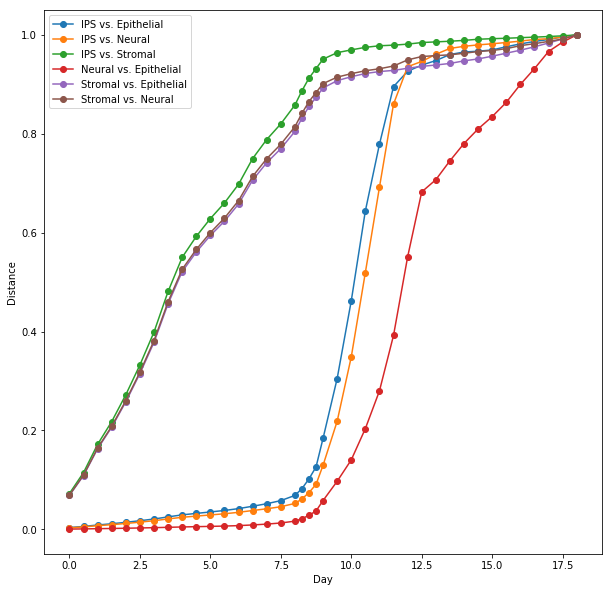

In [17]:
divergence_df['name'] = divergence_df['name1'].str.split('/').str.get(0) + ' vs. ' + divergence_df['name2'].str.split('/').str.get(
        0)
plt.figure(figsize=(10, 10))
plt.xlabel("Day")
plt.ylabel("Distance")
for p, d in divergence_df.groupby('name'):
    plt.plot(d['day2'], d['distance'], '-o', label=p)
plt.legend(loc='best')

# Ancestor Census